Data gathering

analysis of 2 or 3 different kind of algorithms we will use: kNN, maxent, logistic regression, deep learning, and support vector machines.

each method has a different pre processing and strengths and interpretatio


kNN- tokenizing, all lower case, removing common words, lematisize, tagging words as preposition/conjunction/etc,  TF IDF

Do we remove stop words, or not?
Do we stem or lemmatize our text data, or leave the words as is?
Is basic tokenization enough, or do we need to support special edge cases through the use of regex?
Do we stick with English words only or do we allow for other languages?
Do we use the entire vocabulary, or just limit the model to a subset of the most frequently used words? If so, how many?

In [1]:
#!pip install Levenshtein
#!pip install pandas
#!pip install nltk
#!pip install Levenshtein
#!pip install textblob
#!pip install scikit-learn
#!pip install xgboost

In [2]:
#imports

import numpy as np
from textblob import TextBlob
import random
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import neighbors
import sklearn.neighbors
import sklearn.metrics as metrics
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.decomposition import PCA
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
import re
import os
import nltk
import Levenshtein
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords
import string
from scipy.interpolate import make_interp_spline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import AdaBoostClassifier
from collections import Counter
from sklearn.ensemble import GradientBoostingClassifier
import xgboost as xgb
from sklearn.ensemble import VotingClassifier
from sklearn.ensemble import BaggingClassifier

In [3]:
#nltk.download('punkt')
#nltk.download('averaged_perceptron_tagger')
#nltk.download('maxent_ne_chunker')
#nltk.download('words')

In [4]:
import shutil

def zip_folder(folder_path, zip_path):
    shutil.make_archive(zip_path, 'zip', folder_path)

# Example usage
#folder_path = '/home/jovyan/persistent/CSE204/FINAL_PROJECT/Raw_Songs_DataBase'  # Replace with the path to your folder
#zip_path = '/home/jovyan/persistent/CSE204/FINAL_PROJECT'  # Replace with the desired path and name for the zip file

#zip_folder(folder_path, zip_path)

In [5]:
def read_file(file_path):
    
    with open(file_path, 'r') as file:
        text = file.read()
    return text

In [6]:
#DEFINE A MAX NUMBER OF ARTISTS
NUMBER_OF_ARTISTS = 100

In [7]:
#get the data

path_to_songs = os.path.join(os.getcwd(), "Raw_Songs_DataBase2")

artists = os.listdir(path_to_songs)
artists_all = [art for art in artists if art[0] != "."]
artists = random.sample(artists_all, NUMBER_OF_ARTISTS)
artists = sorted(artists)

x = []
RID_features = []
y = []

songs_per_artist={art : 0 for art in artists}

titles = []

for art in artists: 
    

    path_to_artist = os.path.join(path_to_songs, art)
    path_to_artist_songs = os.path.join(path_to_artist, "Songs")
    #path_to_rid = os.path.join(path_to_artist, "Songs")
    
    songs = os.listdir(path_to_artist_songs)
    for song in songs:
        if song[0] != ".":
            if song[-3:] != "RID":
                path = os.path.join(path_to_artist_songs, song)
                titles.append(song)
                lyrics =  read_file(path)
                x.append(lyrics)
                songs_per_artist[art] += 1
                y.append(art)
            else: #is a RID file
                path = os.path.join(path_to_artist_songs, song)
                text =  read_file(path)
                RID_features.append(text)

    
arts_dict = {}
for i in range(len(artists)):
    arts_dict[artists[i]] = i
    
arts_dict_op = {i: artist for artist, i in arts_dict.items()}
    
for i in range(len(y)):
    art = y[i]
    y[i] = int(arts_dict[art])

x = np.array(x)
y = np.array(y) 
titles = np.array(titles)

assert len(x) == len(RID_features)

In [8]:
save_dir = os.path.join(os.getcwd(), "saved_plots")

In [9]:
#remove all that is into paranthesis in the titles
for i in range(len(titles)):
    titles[i] = re.sub(r'\([^()]+\)', '', titles[i]).strip()


Now let us get some data about the songs

Number of songs : 11912
Number of artists : 100
Average number of songs per artist : 119


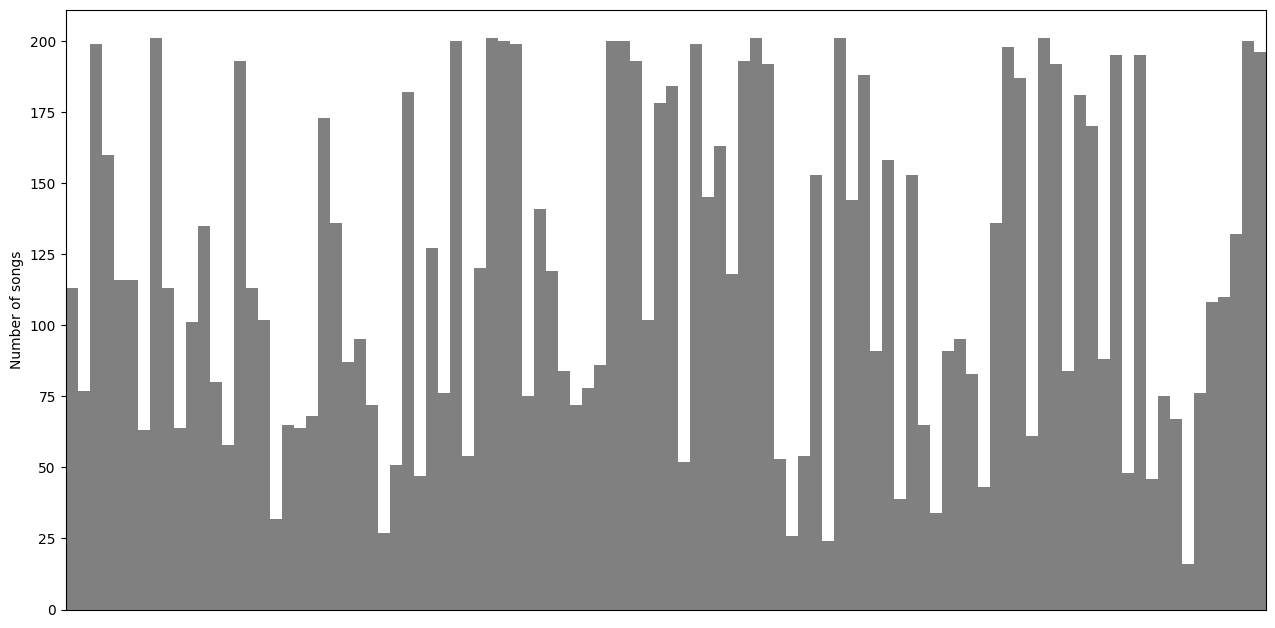

In [10]:
print(f'Number of songs : {len(x)}')
print(f'Number of artists : {len(artists)}')
print(f'Average number of songs per artist : {int(len(x)/len(artists))}')

keys = songs_per_artist.keys()
values = songs_per_artist.values()

fig = plt.figure(figsize=(12, 6))  # Set the figure size
fig.subplots_adjust(left=0, right=1, top=1, bottom=0)  # Adjust margins

bar_lefts = range(len(keys))
bar_heights = values

plt.bar(bar_lefts, bar_heights, width=1.0, facecolor='gray')  # Customize the appearance

plt.ylabel('Number of songs')

plt.xticks([])  # Remove x-axis tick labels
plt.xlabel('')  # Remove x-axis legend

plt.xlim(-0.5, len(keys) - 0.5)  # Adjust x-axis limits

plt.show()

In [11]:
def flatten(text):
    text = [word for sentence in text for word in sentence]
    return text

In [12]:
def pre_processing(text):
    
    text = text.lower() #lowercase
    
    #split in lines
    text = text.split("\n") 
    
    #remove useless punctuation
    punctuation = r'[/()-.?!,";{}]'
    text= [re.sub(punctuation,"", sentence) for sentence in text]
    
    #seperate each word
    text = [line.split(' ') for line in text]
    
    #flatten the list of lists

    
    #remove empty lines
    text = [line for line in text if len(line)!=0]
    
    
    #remove all expressions in between brackets and empty words
    text = [ [word.strip() for word in line if len(word) != 0 and word[0]!= "["] for line in text]
    
    #remobe empty lines again
    text = [line for line in text if len(line)!=0]
    nb_lines = len(text)
    
    #stemmatization
    ps = PorterStemmer()
    text = [[ps.stem(word) for word in line] for line in text]
    
    nb_words = 0
    for line in text:
        nb_words += len(line)


    return text, nb_lines, nb_words

def title_pre_processing(title):
    title = title.lower()  # lowercase
    #title = re.sub(r'\.txt$', '', title)  # remove .txt extension
    punctuation = r'[-.?!,";/]'
    title = re.sub(punctuation, "", title)
    title = re.sub(r'[\(\[].*?[\)\]]', '', title)
    title = title.strip()
    return title

Let's vizualize the data

In [13]:
data = []
for i in range(len(x)):
    song = x[i]
    point = list(pre_processing(song))
    point.append(song)
    t = title_pre_processing(titles[i])
    point.append(t)
    point.append(y[i])
    data.append(point)
    

In [14]:
df = pd.DataFrame(data, columns=['Lyrics', 'Nb_Lines', 'Nb_Words', 'Raw_Lyrics', 'Title', 'Artist'])
df.head()

,Lyrics,Nb_Lines,Nb_Words,Raw_Lyrics,Title,Artist
0,"[[take, it, easi, with, me, pleas], [touch, me...",47,260,"\nTake it easy with me, please\nTouch me gentl...",andante andante,0
1,"[[ahhaha, ahaaaah], [ahhaha, ahaaaah], [ahhaha...",49,313,"\nAh-ha-ha, ah-aaaah\nAh-ha-ha, ah-aaaah\nAh-h...",angeleyes,0
2,"[[day, is, dawn, and, i, must, go], [you'r, as...",28,190,\nDay is dawning and I must go\nYou're asleep ...,another town another train,0
3,"[[i'll, never, know, whi, i, had, to, go], [wh...",33,312,\nI'll never know why I had to go\nWhy I had t...,as good as new,0
4,"[[babi], [you, can, do, magic], [babi], [isn't...",15,49,\nBaby\nYou can do magic\nBaby\nIsn't it tragi...,baby,0


In [15]:
def plot_box_graph(features):
    
    nb_graphs = len(features)
    if nb_graphs == 1:
        feature = features[0]
        to_plot = []
        for art in sample:
            d1 = df.loc[df['Artist'] == art, feature]
            to_plot.append(d1.tolist())
        plt.boxplot(to_plot)
        xtick_labels = [arts_dict_op[i] for i in sample]
        plt.gca().set_xticklabels(xtick_labels, rotation='vertical', fontsize=8)
        plt.title(feature)

        plt.show()
    else:
        fig, graphs = plt.subplots(1, nb_graphs, figsize=(10, 4), gridspec_kw={'wspace': 0.3})
    
        plots = [[] for _ in range(nb_graphs)]

        for art in sample:
            for i in range(len(features)):
                feature = features[i]
                d = df.loc[df['Artist'] == art, feature]
                plots[i].append(d)
        
        for i in range(len(plots)):
            graphs[i].boxplot(plots[i])

        xtick_labels = [arts_dict_op[i] for i in sample]
        
        for i in range(len(features)):
            feature = features[i]
            graphs[i].set_xticklabels(xtick_labels, rotation='vertical', fontsize=8)
            graphs[i].set_title(feature)

        
        plt.show()
        
def plot_bar_graph(feature):

    to_plot = []
    for art in sample:
        d1 = df.loc[df['Artist'] == art, feature]
        to_plot.append(d1.mean())

    plt.bar(np.arange(len(to_plot)), to_plot) 
    xtick_labels = [arts_dict_op[i] for i in sample]
    plt.xticks(np.arange(len(to_plot)), xtick_labels, rotation='vertical', fontsize=8)  
    plt.title(feature)

    plt.show()

In [16]:
#let's add the RID columns
def RID_dict(text):
    text = text.split("\n")
    text = [re.findall(r'\d+(?:\.\d+)?|\D+', t) for t in text]
    #text = [t.split(' ') for t in text if len(t)!=0 and t[0].isupper()]
    text = [[word.strip() for word in t if re.match(r'^[A-Z0-9.]', word)] for t in text]
    text = [arr for arr in text if len(arr) != 0]
    summary = text[-4:-1]
    details = text[:-4]
    lenght = text[-1][0]
    details = [ [word.replace(' ', ':') for word in line] for line in details]
    summary = [ [s.replace(':', '').strip() for s in line] for line in summary]
    summary = [ [s.replace(':', '').strip() for s in line] for line in summary]

    details = {d[0] : (int(d[1]))/(int(lenght)) for d in details}
    #details = {d[0] : int(d[1]) for d in details}
    summary = {d[0] : float(d[1]) for d in summary}
    
    return details, summary

RID_DETAILS = {}
RID_SUMMARY = {'RID_PRIMARY': [], 'RID_SECONDARY' : [], 'RID_EMOTIONS' : []}

#first let's get the labels
for rid in RID_features:
    d, s = RID_dict(rid)
    for key in d.keys():
        if key not in RID_DETAILS.keys():
            RID_DETAILS['RID_'+key] = []

#now fill in the values
for rid in RID_features:
    d, s = RID_dict(rid)
    for key in RID_DETAILS.keys():
        if key[4:] in d.keys():
            RID_DETAILS[key].append(d[key[4:]])
        else:
            RID_DETAILS[key].append(0)
    for key in s.keys():
        RID_SUMMARY['RID_'+key].append(s[key])


In [17]:
df = df.assign(**RID_DETAILS)
df = df.assign(**RID_SUMMARY)
df.head()

,Lyrics,Nb_Lines,Nb_Words,Raw_Lyrics,Title,Artist,RID_SECONDARY:INSTRUMENTAL:BEHAVIOR,RID_EMOTIONS:EXPRESSIVE:BEHAVIOR,RID_SECONDARY:TEMPORAL:REFERENCES,RID_PRIMARY:SENSATION:SOUND,...,RID_PRIMARY:NEED:ORALITY,RID_PRIMARY:SENSATION:HARD,RID_PRIMARY:ICARIAN:IMAGERY:DESCENT,RID_PRIMARY:DEFENSIVE:SYMBOLIZATION:CHAOS,RID_PRIMARY:DEFENSIVE:SYMBOLIZATION:RANDOM:MOVEMENT,RID_PRIMARY:REGRESSIVE:COGNITION:TIMELESSNESS,RID_PRIMARY:SENSATION:ODOR,RID_PRIMARY,RID_SECONDARY,RID_EMOTIONS
0,"[[take, it, easi, with, me, pleas], [touch, me...",47,260,"\nTake it easy with me, please\nTouch me gentl...",andante andante,0,0.066176,0.040441,0.036765,0.033088,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,33.766234,49.350649,16.883117
1,"[[ahhaha, ahaaaah], [ahhaha, ahaaaah], [ahhaha...",49,313,"\nAh-ha-ha, ah-aaaah\nAh-ha-ha, ah-aaaah\nAh-h...",angeleyes,0,0.032877,0.005479,0.024658,0.008219,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,39.240506,51.898734,8.860759
2,"[[day, is, dawn, and, i, must, go], [you'r, as...",28,190,\nDay is dawning and I must go\nYou're asleep ...,another town another train,0,0.040816,0.005102,0.015306,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,42.222222,51.111111,6.666667
3,"[[i'll, never, know, whi, i, had, to, go], [wh...",33,312,\nI'll never know why I had to go\nWhy I had t...,as good as new,0,0.015528,0.000000,0.012422,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,28.813559,47.457627,23.728814
4,"[[babi], [you, can, do, magic], [babi], [isn't...",15,49,\nBaby\nYou can do magic\nBaby\nIsn't it tragi...,baby,0,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,12.500000,50.000000,37.500000


In [18]:
s1 = df.shape[0]
df = df.drop_duplicates(subset=['Title', 'Artist'])
s2 = df.shape[0]
print(f'Dropped {s1 - s2} duplicates')

raw_songs = df["Raw_Lyrics"].to_list()

Dropped 124 duplicates


In [19]:
df = df[df['Nb_Words'] >= 50]
s3 = df.shape[0]

print(f'Dropped {s2 - s3} songs that were too short')

df = df[~df['Title'].str.contains('intro', case=False)]
df = df[~df['Title'].str.contains('outro', case=False)]
s4 = df.shape[0]

print(f'Dropped {s3 - s4} intros and outros')

Dropped 161 songs that were too short
Dropped 11 intros and outros


In [20]:
def dropping_artists():
    # Compute the count of instances for each artist
    artist_counts = df['Artist'].value_counts()

    # Identify artists with counts less than 50
    artists_to_drop = artist_counts[artist_counts < 70].index

    # Create a boolean mask indicating rows to be dropped
    mask = df['Artist'].isin(artists_to_drop)

    # Filter and drop the corresponding rows from the DataFrame
    df.drop(df[mask].index, inplace=True)

    l1 = len(artists)
    # Remove the artists from the artists array
    new_artists = [art for art in artists if arts_dict[art] not in artists_to_drop]
    dropped_artists = [art for art in artists if arts_dict[art] in artists_to_drop]
    for art in dropped_artists:
        del arts_dict_op[arts_dict[art]]
        del arts_dict[art]

    l2 = len(new_artists)


    s5 = df.shape[0]
    print(f'Dropped {l1 - l2} artists that had too few songs : -{s4 - s5} songs')
    
dropping_artists()

Dropped 27 artists that had too few songs : -1294 songs


In [21]:
#FUNCTIONS TO MEASURE SIMILARITY

def levenshtein_similarity(text1, text2):
    distance = Levenshtein.distance(text1, text2)
    max_length = max(len(text1), len(text2))
    similarity = (max_length - distance) / (max_length + 1)
    return similarity

def jaccard_similarity(text1, text2):
    set1 = set(text1)
    set2 = set(text2)
    intersection = len(set1.intersection(set2))
    union = len(set1.union(set2))
    similarity = intersection / (union + 1)
    return similarity

In [22]:
# Create a mask to identify the rows to drop
mask = np.zeros(len(df), dtype=bool)


for idx1, row1 in df.iterrows():
    song1 = row1["Raw_Lyrics"]
    title1 = row1["Title"]
    artist1 = row1["Artist"]
    
    # Filter rows with the same title but different artist
    duplicate_rows = df[(df["Title"] == title1) & (df["Artist"] != artist1)]
    
    
    # Calculate similarity scores between song1 and duplicate rows
    similarity_scores_lev = duplicate_rows["Raw_Lyrics"].apply(lambda x: levenshtein_similarity(song1, x))
    
    # Identify rows with similarity scores above 0.8
    similar_rows_lev = duplicate_rows[similarity_scores_lev > 0.8]

    
    
    df.drop(similar_rows_lev.index, inplace=True)

# Drop the marked rows using the mask
#df.drop(df.index[mask], inplace=True)

s3 = df.shape[0]
print(f'Dropped {s2 - s3} covers')

Dropped 1595 covers


In [23]:
artist_counts = df['Artist'].value_counts()

artist_most_songs = artist_counts.idxmax()
most_songs_count = artist_counts.max()

artist_least_songs = artist_counts.idxmin()
least_songs_count = artist_counts.min()

print(f"Artist with the most songs: {artists[artist_most_songs]} ({most_songs_count} songs)")
print(f"Artist with the least songs: {artists[artist_least_songs]} ({least_songs_count} songs)")

Artist with the most songs: Reba McEntire (200 songs)
Artist with the least songs: Gap Band (72 songs)


In [24]:
def undersampling():
    # Identify artists with a total number of songs greater than 130
    artists_above_threshold = artist_counts[artist_counts > 130].index

   
    for artist in artists_above_threshold:
        # Get the indices of songs by the current artist
        artist_indices = df[df['Artist'] == artist].index

        # Calculate the number of songs to be dropped
        songs_to_drop = len(artist_indices) - 130

        # Randomly select and drop songs until count reaches 130
        songs_to_keep = np.random.choice(artist_indices, size=130, replace=False)
        df.drop(artist_indices.difference(songs_to_keep), inplace=True)

    s7 = df.shape[0]
    print(f'Dropped {s6 - s7} songs from undersampling too represented artists')

In [25]:
print("AFTER CLEANING\n")

print(f'Number of songs : {df.shape[0]}')
print(f'Number of artists : {len(arts_dict)}')
print(f'Average number of songs per artist : {int((df.shape[0])/len(arts_dict))}')

AFTER CLEANING

Number of songs : 10193
Number of artists : 73
Average number of songs per artist : 139


In [26]:
if NUMBER_OF_ARTISTS > 10:
    sample = random.sample(list(arts_dict_op.keys()), 10)
else:
    sample = random.sample(list(arts_dict_op.keys()), NUMBER_OF_ARTISTS)

In [27]:
#plot_box_graph(["RID_PRIMARY", "RID_EMOTIONS"])

In [28]:
df_rid = df.filter(regex=r'^RID')
df_rid

,RID_SECONDARY:INSTRUMENTAL:BEHAVIOR,RID_EMOTIONS:EXPRESSIVE:BEHAVIOR,RID_SECONDARY:TEMPORAL:REFERENCES,RID_PRIMARY:SENSATION:SOUND,RID_SECONDARY:SOCIAL:BEHAVIOR,RID_PRIMARY:SENSATION:VISION,RID_PRIMARY:SENSATION:SOFT,RID_SECONDARY:ABSTRACTION,RID_PRIMARY:SENSATION:TOUCH,RID_EMOTIONS:AFFECTION,...,RID_PRIMARY:NEED:ORALITY,RID_PRIMARY:SENSATION:HARD,RID_PRIMARY:ICARIAN:IMAGERY:DESCENT,RID_PRIMARY:DEFENSIVE:SYMBOLIZATION:CHAOS,RID_PRIMARY:DEFENSIVE:SYMBOLIZATION:RANDOM:MOVEMENT,RID_PRIMARY:REGRESSIVE:COGNITION:TIMELESSNESS,RID_PRIMARY:SENSATION:ODOR,RID_PRIMARY,RID_SECONDARY,RID_EMOTIONS
0,0.066176,0.040441,0.036765,0.033088,0.025735,0.018382,0.011029,0.011029,0.007353,0.007353,...,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.000000,33.766234,49.350649,16.883117
1,0.032877,0.005479,0.024658,0.008219,0.002740,0.038356,0.000000,0.041096,0.000000,0.002740,...,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.000000,39.240506,51.898734,8.860759
2,0.040816,0.005102,0.015306,0.000000,0.010204,0.005102,0.000000,0.045918,0.000000,0.010204,...,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.000000,42.222222,51.111111,6.666667
3,0.015528,0.000000,0.012422,0.000000,0.015528,0.003106,0.000000,0.043478,0.000000,0.040373,...,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.000000,28.813559,47.457627,23.728814
5,0.011673,0.000000,0.019455,0.143969,0.007782,0.003891,0.000000,0.031128,0.003891,0.042802,...,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.000000,59.493671,22.784810,17.721519
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11907,0.008299,0.008299,0.012448,0.000000,0.008299,0.029046,0.000000,0.020747,0.000000,0.000000,...,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.000000,48.275862,25.862069,25.862069
11908,0.024272,0.009709,0.024272,0.009709,0.009709,0.009709,0.000000,0.004854,0.000000,0.014563,...,0.004854,0.000000,0.0,0.0,0.009709,0.0,0.000000,35.483871,41.935484,22.580645
11909,0.022951,0.006557,0.045902,0.013115,0.026230,0.003279,0.000000,0.016393,0.000000,0.013115,...,0.000000,0.006557,0.0,0.0,0.000000,0.0,0.000000,24.210526,36.842105,38.947368
11910,0.100000,0.000000,0.019048,0.004762,0.004762,0.014286,0.000000,0.019048,0.000000,0.028571,...,0.014286,0.000000,0.0,0.0,0.004762,0.0,0.004762,32.758621,53.448276,13.793103


In [29]:
# Instantiate PCA with the number of components set to the total number of features
pca = PCA(n_components=len(df_rid.columns))

# Fit PCA on the standardized features
pca.fit(df_rid)

# Get the explained variance ratio of each principal component
explained_variance_ratio = pca.explained_variance_ratio_

# Sort the variance ratios in descending order
sorted_variance_ratio = sorted(explained_variance_ratio, reverse=True)

# Get the indices of the top 10 features with the most variance
top_10_indices = np.argsort(explained_variance_ratio)[::-1][:10]

# Keep only the top 10 features in the DataFrame
df_top_10 = df_rid.iloc[:, top_10_indices]
df_top_10.columns

Index(['RID_SECONDARY:INSTRUMENTAL:BEHAVIOR',
       'RID_EMOTIONS:EXPRESSIVE:BEHAVIOR', 'RID_SECONDARY:TEMPORAL:REFERENCES',
       'RID_PRIMARY:SENSATION:SOUND', 'RID_SECONDARY:SOCIAL:BEHAVIOR',
       'RID_PRIMARY:SENSATION:VISION', 'RID_PRIMARY:SENSATION:SOFT',
       'RID_SECONDARY:ABSTRACTION', 'RID_PRIMARY:SENSATION:TOUCH',
       'RID_EMOTIONS:AFFECTION'],
      dtype='object')

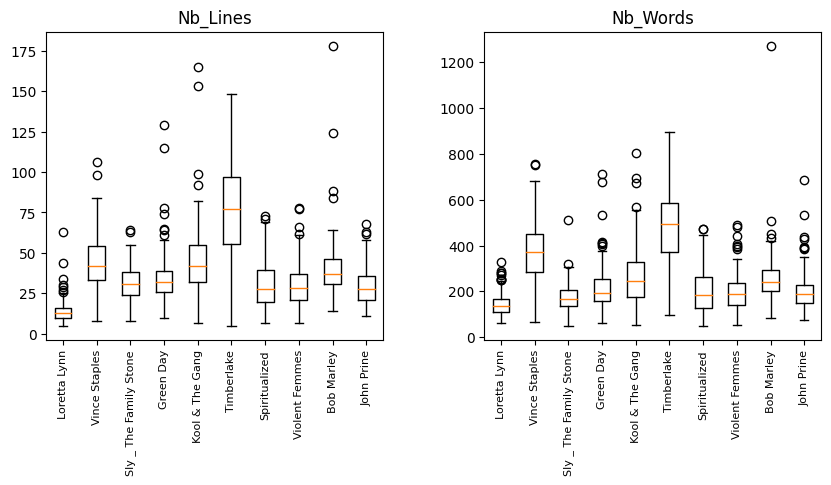

In [30]:
plot_box_graph(["Nb_Lines", "Nb_Words"])

In [31]:
df["Nb_Words_Per_Line"] = df["Nb_Words"]/df["Nb_Lines"]

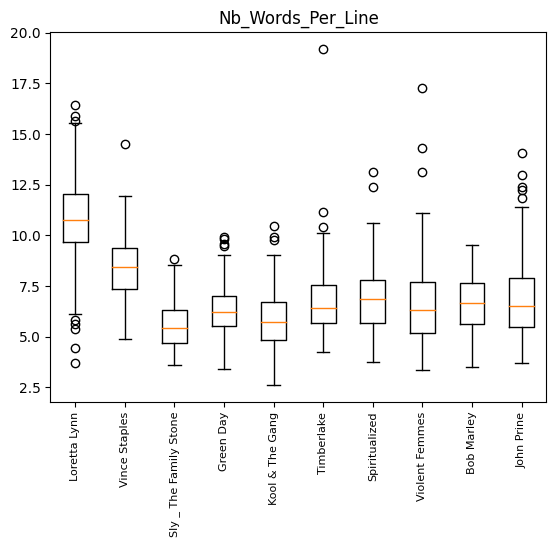

In [32]:
plot_box_graph(["Nb_Words_Per_Line"])

We add a new feature: Type-Token ratio. It shows how repetitive a song is.

In [33]:
songs = df["Lyrics"].to_list()
songs_flatten = [[word for line in song for word in line] for song in songs]
nb_words = df["Nb_Words"].to_list()

#unique word means appears only once in the song
TTR = []
for song, l in zip(songs_flatten, nb_words):
    dic = {word: 0 for word in song}
    non_unique_words = set()
    for word in song:
        dic[word] += 1
        if dic[word] > 1: #if it appeared more than once, add it
            non_unique_words.add(word)
    nb_unique_words = l - len(non_unique_words)
    ttr = nb_unique_words / l
    TTR.append(ttr)
    
df['TTR'] = TTR

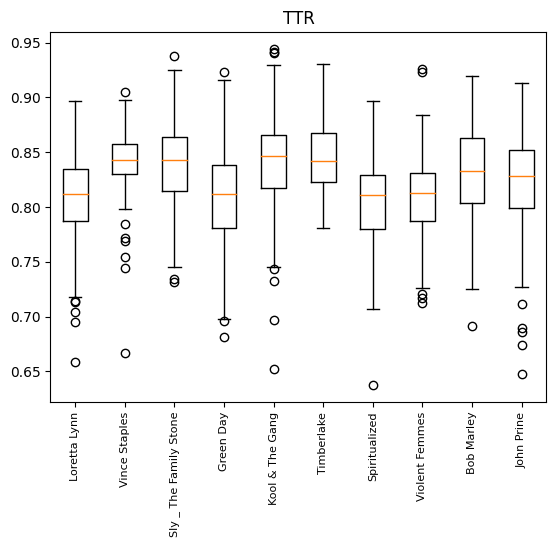

In [34]:
plot_box_graph(["TTR"])

In [35]:
import itertools

raw_songs = df["Raw_Lyrics"].to_list()
nb_lines = df["Nb_Lines"].to_list()

lines_similarity_jacc = []
#lines_similarity_lev= []

examples = []

for song, num_lines in zip(songs, nb_lines):
    line_similarity_count_jacc = 0
    
    for line1, line2 in itertools.combinations(song, 2):
        similarity_jacc = jaccard_similarity(line1, line2)
        
        
        if  similarity_jacc > 0.5:  # Adjust the threshold as needed
            line_similarity_count_jacc += 1
            examples.append([line1, line2])
    
    lines_similarity_jacc.append(line_similarity_count_jacc)
    

df["Lines_similarity"] = lines_similarity_jacc

In [36]:
reduced_examples = random.choices(examples, k=5)
for ex in reduced_examples:
    for l in ex:
        print(l)
    print("\n")

['everi', 'second', 'someon', 'break', 'a', 'heart']
['everi', 'second', 'someon', 'break', 'a', 'heart']


["i'm", 'go', 'to', 'reach', 'way', 'up', 'and', 'out', 'and', 'touch', 'everybodi']
["i'm", 'go', 'to', 'reach', 'way', 'up', 'and', 'out', 'and', 'touch', 'everybodi']


["he'", 'on', 'hi', 'way', 'to', 'hollywood']
["he'", 'on', 'hi', 'way', 'to', 'hollywood']


['number', 'one']
['number', 'one']


['nobodi', 'should', 'be', "grievin'", 'thi', 'way']
['nobodi', 'should', 'be', "grievin'", 'thi', 'way']




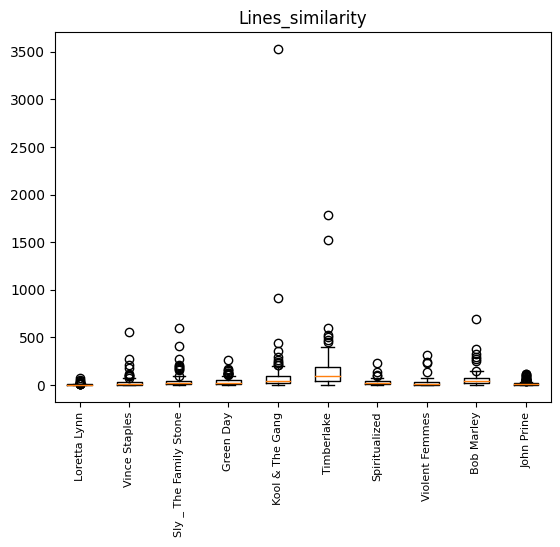

In [37]:
plot_box_graph(["Lines_similarity"])

In [38]:
filtered_df = df.loc[df["Lines_similarity"] > 1000]

In [39]:
supertags_dict = {
    'VB': 'V', 'VBD': 'V', 'VBG': 'V', 'VBN': 'V', 'VBP': 'V', 'VBZ': 'V', #verbs
    'NN': 'N', 'NNS': 'N', 'NNP': 'N', 'NNPS': 'N', #nouns
    'RB': 'ADV', 'RBR': 'ADV', 'RBS': 'ADV', 'WRB': 'ADV', #adverbs
    'JJ': 'ADJ', 'JJR': 'ADJ', 'JJS': 'ADJ', #adjectives
    'DT': 'DET', 'PDT': 'DET', 'WDT': 'DET', #determinents
    'PRP': 'PRON', 'PRP$': 'PRON', 'WP': 'PRON', 'WP$': 'PRON'} #pronouns

supertags = ['N', 'V', 'ADV', 'ADJ', 'DET', 'PRON']
chunk_tags = ['GPE', 'PERSON', 'ORGANIZATION', 'LOCATION', 'FACILITY', 'GSP']

#'GPE': 'Geopolitical Entity: Refers to countries, cities, states, or regions.',
#'PERSON': 'Person: Refers to individuals or groups of people.',
#'ORGANIZATION': 'Organization: Refers to named entities representing companies, institutions, or groups.',
#'LOCATION': 'Location: Refers to specific places or locations.',
#'FACILITY': 'Facility: Refers to buildings, structures, or other physical facilities.',
#'GSP': 'General Single Purpose: Refers to a general chunk tag with a single-purpose label.'

def split_sentences(text):

    text = re.sub(r'\([^()]*\)', ' ', text)
    text = text.replace('(', ' ')
    text = text.replace(')', ' ')
    text = text.replace('  ', ' ')
    sentences = re.split(r'(?:[.!?])|\n\n', text)
    sentences = [s.strip() for s in sentences if len(s)!=0]
    return sentences

In [40]:
def pos_chunk(text):
    # Tokenize into sentences and words
    sentences = split_sentences(text)
    words = [nltk.word_tokenize(sent) for sent in sentences]
    
    # POS tagging
    pos_tags = [nltk.pos_tag(sent) for sent in words]
    
    # Chunking
    chunked_sentences = [nltk.ne_chunk(pos_tag_sent) for pos_tag_sent in pos_tags]

    # Calculate POS tag distribution
    pos_tag_distribution = {suptag: 0 for suptag in supertags}
    for sent in pos_tags:
        pos_tag_distribution.update({supertags_dict[tag]: pos_tag_distribution.get(supertags_dict[tag], 0) + 1
                                     for _, tag in sent if tag in supertags_dict})

    # Calculate chunk tag distribution
    chunk_tag_distribution = {chunk_tag: 0 for chunk_tag in chunk_tags}
    for sent in chunked_sentences:
        chunk_tag_distribution.update({chunk.label(): chunk_tag_distribution.get(chunk.label(), 0) + 1
                                       for chunk in sent if hasattr(chunk, 'label') and chunk.label() in chunk_tags})

    return pos_tag_distribution, chunk_tag_distribution


In [41]:
raw_songs = df["Raw_Lyrics"].to_list()
#df = df.drop("Raw_Lyrics", axis = 1)
nb_words = df["Nb_Words"].to_list()

In [42]:

POS = {'POS_'+key : [] for key in supertags}

CHUNK = {'CHUNK_'+key : [] for key in chunk_tags}

for raw, l in zip(raw_songs, nb_words):
    pos, chunk = pos_chunk(raw)
    for key in pos.keys():
        POS['POS_'+key].append(pos[key] / l)
        
    for key in chunk.keys():
        CHUNK['CHUNK_'+key].append(chunk[key] / l)

In [43]:
df = df.assign(**POS)
df = df.assign(**CHUNK)
df.head()

,Lyrics,Nb_Lines,Nb_Words,Raw_Lyrics,Title,Artist,RID_SECONDARY:INSTRUMENTAL:BEHAVIOR,RID_EMOTIONS:EXPRESSIVE:BEHAVIOR,RID_SECONDARY:TEMPORAL:REFERENCES,RID_PRIMARY:SENSATION:SOUND,...,POS_ADV,POS_ADJ,POS_DET,POS_PRON,CHUNK_GPE,CHUNK_PERSON,CHUNK_ORGANIZATION,CHUNK_LOCATION,CHUNK_FACILITY,CHUNK_GSP
0,"[[take, it, easi, with, me, pleas], [touch, me...",47,260,"\nTake it easy with me, please\nTouch me gentl...",andante andante,0,0.066176,0.040441,0.036765,0.033088,...,0.023077,0.019231,0.011538,0.023077,0.000000,0.023077,0.0,0.0,0.0,0.0
1,"[[ahhaha, ahaaaah], [ahhaha, ahaaaah], [ahhaha...",49,313,"\nAh-ha-ha, ah-aaaah\nAh-ha-ha, ah-aaaah\nAh-h...",angeleyes,0,0.032877,0.005479,0.024658,0.008219,...,0.015974,0.025559,0.019169,0.025559,0.000000,0.003195,0.0,0.0,0.0,0.0
2,"[[day, is, dawn, and, i, must, go], [you'r, as...",28,190,\nDay is dawning and I must go\nYou're asleep ...,another town another train,0,0.040816,0.005102,0.015306,0.000000,...,0.015789,0.015789,0.015789,0.015789,0.000000,0.000000,0.0,0.0,0.0,0.0
3,"[[i'll, never, know, whi, i, had, to, go], [wh...",33,312,\nI'll never know why I had to go\nWhy I had t...,as good as new,0,0.015528,0.000000,0.012422,0.000000,...,0.019231,0.016026,0.019231,0.019231,0.003205,0.006410,0.0,0.0,0.0,0.0
5,"[[make, somebodi, happi, is, a, question, of, ...",34,200,\nMaking somebody happy is a question of give ...,bangaboomerang,0,0.011673,0.000000,0.019455,0.143969,...,0.020000,0.030000,0.025000,0.025000,0.010000,0.010000,0.0,0.0,0.0,0.0


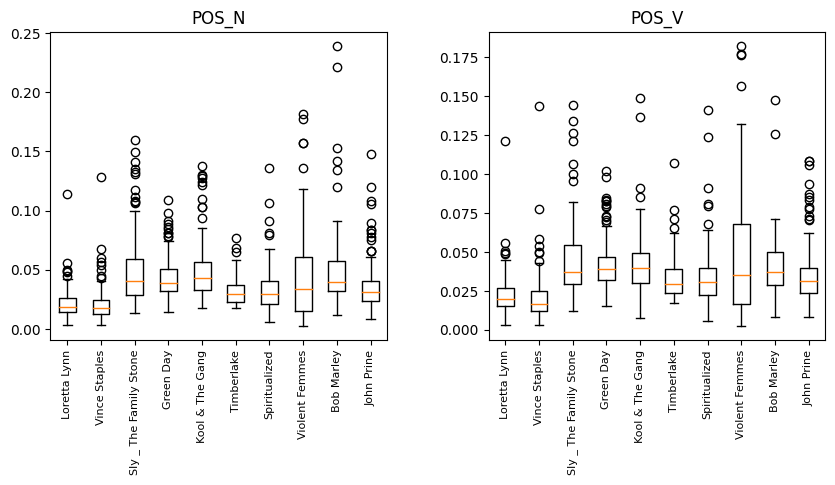

In [44]:
plot_box_graph(["POS_N", "POS_V"])

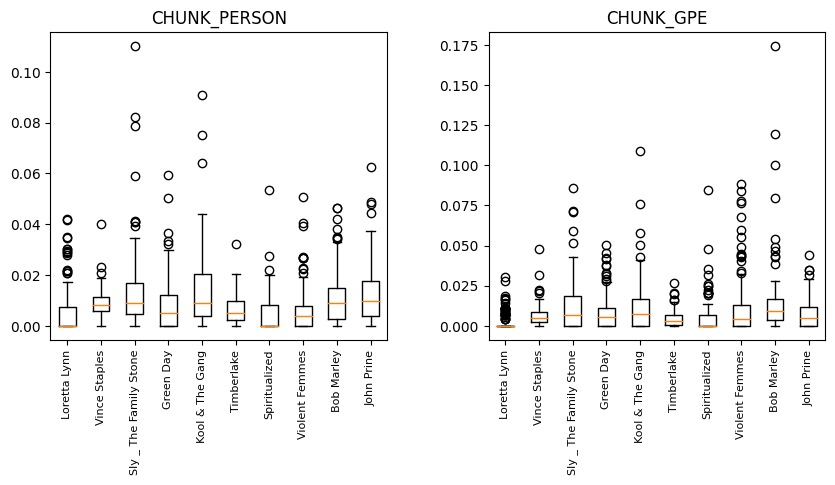

In [45]:
plot_box_graph(["CHUNK_PERSON", "CHUNK_GPE"])

Now we analyze prononces. We count the frequencies of 1st, 2nd, 3rd person pronons and the ratio of 1st person to 2d person to detect dialogue and interpersonal relations.

In [46]:
path_to_dicts = os.path.join(os.getcwd(), "Dictionaries")

path = os.path.join(path_to_dicts, "rare-filtered.txt")
rare = read_file(path)
rare = rare.split("\n")
rare = rare[:-1]

path = os.path.join(path_to_dicts, "slang-filtered.txt")
slang = read_file(path)
slang = slang.split("\n")
slang = slang[:-1]

slang = set(slang)
rare = set(rare)

rare_use = []
slang_use = []

songs_flatten = [flatten(song) for song in songs] 
                 
for song in songs_flatten:
    
    count_r = 0
    count_s = 0
    l = len(song)
    for w in song:
        if w in slang:
            count_s += 1
        if w in rare:
            count_r +=1
    slang_use.append(count_s/l)
    rare_use.append(count_r/l)
    

df['Slang'] = slang_use
df['Rare'] = rare_use

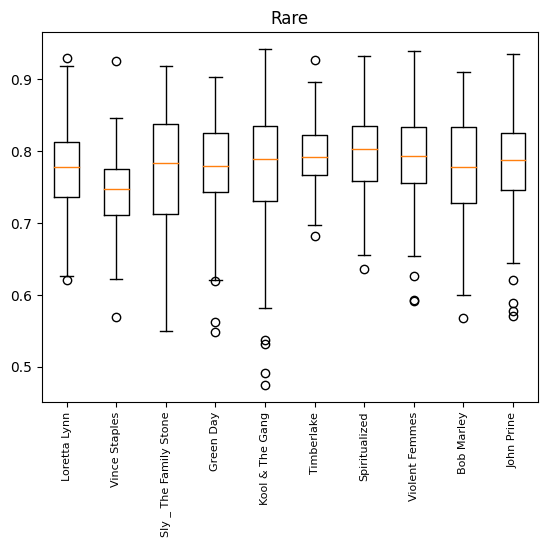

In [47]:
plot_box_graph(["Rare"])

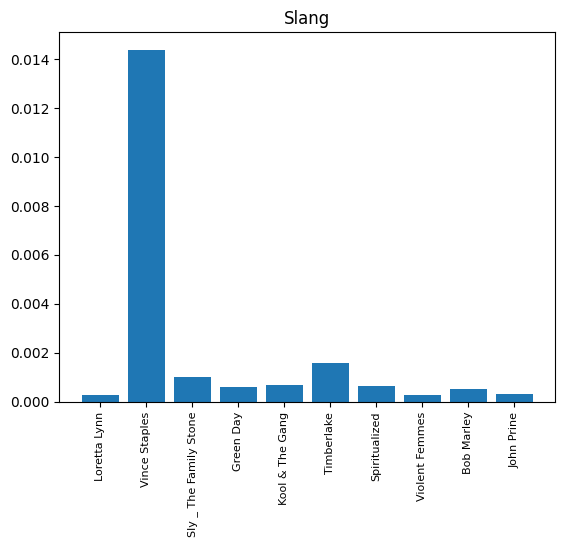

In [48]:
plot_bar_graph("Slang")

In [49]:
first_pers = []
second_pers = []
third_pers = []

for song in songs_flatten:
    first_pers_count = 0
    second_pers_count = 0
    third_pers_count = 0

    for word in song:
        if word in  {"i", "we"}:
            first_pers_count += 1
        if word == "you":
            second_pers_count += 1
        if word in  {"he", "she", "they"}:
            third_pers_count += 1
    
    song_len = len(song)
    first_pers.append(first_pers_count/song_len)
    second_pers.append(second_pers_count/song_len)
    third_pers.append(third_pers_count/song_len)
    
#df['FP_Freq'] = first_pers
#df['SP_Freq'] = second_pers
#df['TP_Freq'] = third_pers

#df["SR"] = df['FP_Freq']/(1 + df['SP_Freq'] + df['TP_Freq'])

In [50]:
#plot_bar_graph("SR")

Now we check whether or not the title appears in the song.

In [51]:
ttls = df["Title"].to_list()

title_in_song = []

raw_songs = [s.lower() for s in raw_songs]


for song, title, art in zip(raw_songs, ttls, df["Artist"].to_list()):
    pattern = re.escape(title)  # Escape special characters in the title
    if re.search(pattern, song):
        flag = True
    else:
        flag = False
    title_in_song.append(flag)


df['Title_In_Song'] = title_in_song
                

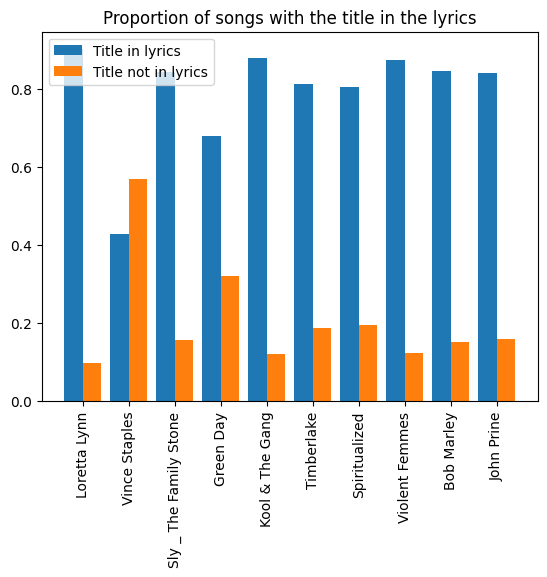

In [52]:
t_in = []
t_not_in = []
total_songs = []

for art in sample:
    songs_by_artist = df.loc[df['Artist'] == art, 'Title_In_Song'].tolist()
    tr = songs_by_artist.count(True)
    fa = songs_by_artist.count(False)
    total_songs.append(len(songs_by_artist))
    t_in.append(tr)
    t_not_in.append(fa)

xtick_labels = [arts_dict_op[i] for i in sample]

X_axis = np.arange(len(xtick_labels))

t_in = np.array(t_in)
t_not_in = np.array(t_not_in)
total_songs = np.array(total_songs)


plt.bar(X_axis - 0.2, t_in/total_songs, 0.4, label='Title in lyrics')
plt.bar(X_axis + 0.2, t_not_in/total_songs, 0.4, label='Title not in lyrics')

plt.xticks(X_axis, xtick_labels, rotation='vertical')
plt.title('Proportion of songs with the title in the lyrics')
plt.legend()
plt.show()
    

In [53]:
sub = []
pol = []
for song in raw_songs:
    scores = TextBlob(song)
    pol.append(scores.sentiment.polarity)
    sub.append(scores.sentiment.subjectivity)
    
df["Polarity"] = pol
df["Subjectivity"] = sub

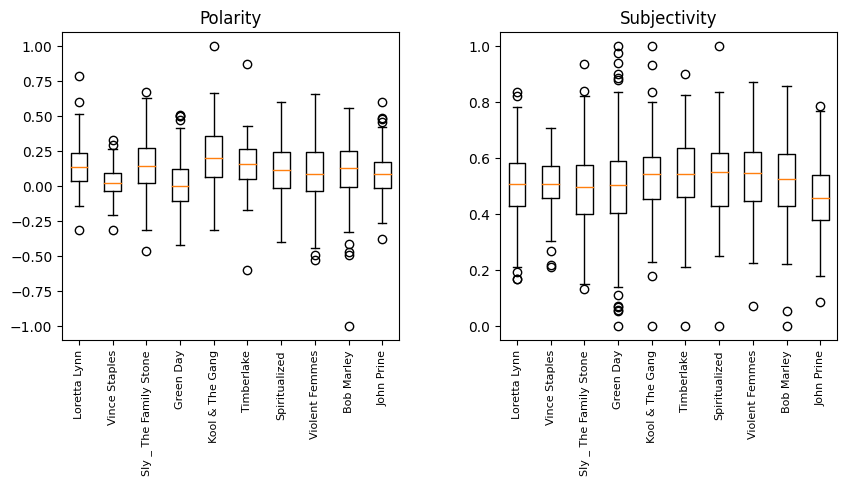

In [54]:
plot_box_graph(["Polarity", "Subjectivity"])

# SPLIT INTO TRAIN AND TEST

In [55]:
df = df.reset_index(drop=True)

artists = df['Artist'].unique()

train_df, test_df = train_test_split(df, test_size=0.15, stratify=df['Artist'])

print(f'Training size : {train_df.shape[0]}')
print(f'Testing size : {test_df.shape[0]}')

Training size : 8664
Testing size : 1529


# TDIDF

In [56]:
documents = []
for i in range(len(arts_dict_op)):
    d = train_df.loc[train_df['Artist'] == i, 'Lyrics'].tolist()
    d = [flatten(song) for song in d]
    d = flatten(d)
    documents.append(d)
    
    
documents = [' '.join(doc) for doc in documents]

df_docs_train = pd.DataFrame({"All_Lyrics" : documents, 
                        "Artist" : np.arange(len(arts_dict_op))})

df_docs_train.head()

,All_Lyrics,Artist
0,you'r so free that' what everybody' tell me ye...,0
1,don't cri dri your eye call me a jerk not 'cau...,1
2,i start to write thi song about you and then i...,2
3,you were a shameless child bandi by stiff cros...,3
4,oh oh oh woke up today feel ok wow thi is new ...,4


At this point we need to seperate train and test sets.

In [57]:
docs = df_docs_train["All_Lyrics"].to_list()

cv = CountVectorizer()
stem_count_vector = cv.fit_transform(docs)
#stem_count_vector = cv.fit_transform(documents)

tfidf_transformer = TfidfTransformer()
tfidf_transformer.fit_transform(stem_count_vector)

# Get the feature names and IDF weights
feature_names = cv.get_feature_names_out()
idf_weights = tfidf_transformer.idf_

df_words_weights = pd.DataFrame({'word': cv.get_feature_names_out(), 'weight': tfidf_transformer.idf_})
 
df_words_weights.sort_values('weight').head()

,word,weight
11414,let,1.315081
11496,light,1.315081
20072,through,1.315081
11516,like,1.315081
5202,deep,1.315081


In [58]:
df_words_weights.sort_values('weight', ascending=False).head()

,word,weight
0,00,4.610918
12713,mislaid,4.610918
12719,misshap,4.610918
12720,misshapen,4.610918
12721,missi,4.610918


In [59]:
df_words_weights.shape[0]

22830

In [60]:
df.shape[0]

10193

In [61]:
def tdif_features(songs):
    
    song_features_list = []

    # Process each song
    for i, song in enumerate(songs):

        # Convert the song to a string
        song_text = ' '.join(song)

        # Transform the song text to a count vector
        song_counts = cv.transform([song_text])

        # Compute the TF-IDF features for the song
        song_features = tfidf_transformer.transform(song_counts)

        # Convert the sparse matrix to a dataframe
        song_features_df = pd.DataFrame(song_features.toarray(), columns=feature_names)

        # Append the song features to the list
        song_features_list.append(song_features_df)

    song_features_list = np.array(song_features_list)
    song_features_list = song_features_list.reshape((song_features_list.shape[0], song_features_list.shape[2]))
    df_tfidf = pd.DataFrame(song_features_list, columns=feature_names)
    df_tfidf['Artist'] = df['Artist'].to_list()
    
    return df_tfidf

In [62]:
df_tfidf = tdif_features(songs_flatten)

In [63]:
df_tfidf.shape

(10193, 22831)

In [64]:
valid_columns = df_tfidf.iloc[:, :-1].select_dtypes(include=np.number)
# Calculate the sum of each row
sum_array = np.array(valid_columns.sum(axis=1))

# Add the sum_array as a new column in the DataFrame
df["TF_IDF_Score"] = sum_array

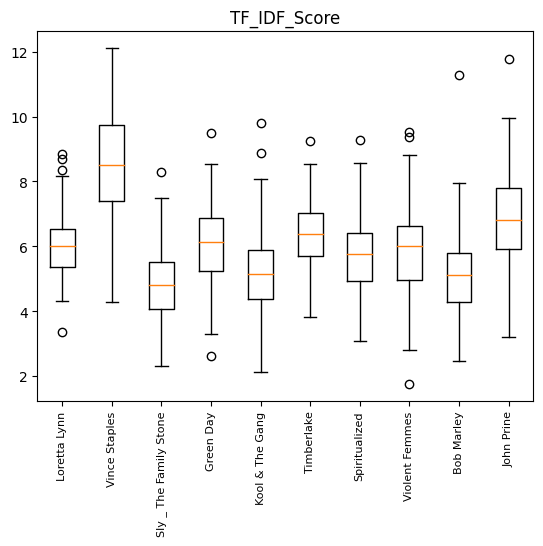

In [65]:
plot_box_graph(["TF_IDF_Score"])

In [66]:
to_keep = df_words_weights.iloc[:1000]["word"].tolist()

In [67]:
df_tfidf_reduced = pd.concat([df_tfidf[column] for column in to_keep], axis=1)

# Display the new DataFrame
df_tfidf_reduced.head()

,00,007,01,02,03,04,05,06,09,0ooo,...,angelin,angelina,angelo,angelu,anger,angkor,angl,anglosaxon,ango,angola
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


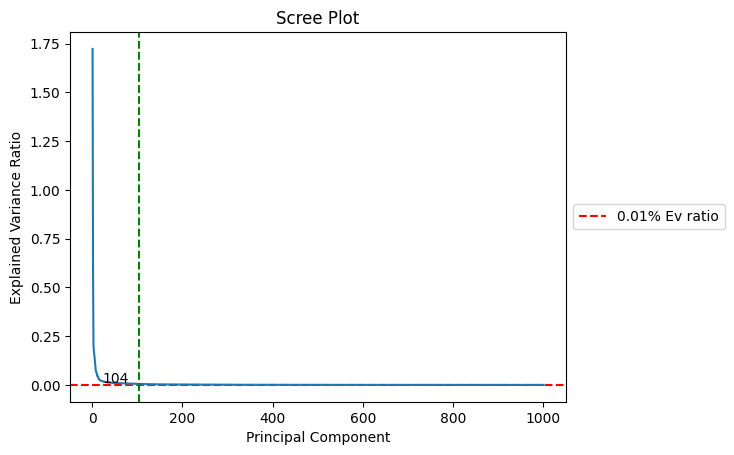

In [68]:
# Perform PCA
pca = PCA()
pca.fit(df_tfidf_reduced)
df_transformed = pca.transform(df_tfidf_reduced)

# Calculate explained variance ratio
explained_variance_ratio = pca.explained_variance_ratio_

plt.axhline(y=0.001, color='r', linestyle='--', label='0.01% Ev ratio')

# Create scree plot
plt.plot(range(1, len(explained_variance_ratio) + 1), explained_variance_ratio*5, marker='', linestyle='-')

# Find the index of intersection
intersection_index = -1
for i in range(len(explained_variance_ratio)):
    if explained_variance_ratio[i] <= 0.001:
        intersection_index = i
        break

# Add a vertical line at the intersection point
plt.axvline(x=intersection_index + 1, color='g', linestyle='--')
plt.text(intersection_index - 50, 0.01, f'{intersection_index + 1}', ha='center')

plt.xlabel('Principal Component')
plt.ylabel('Explained Variance Ratio')
plt.title('Scree Plot')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

# Plot the index of intersection on the x-axis
plt.show()

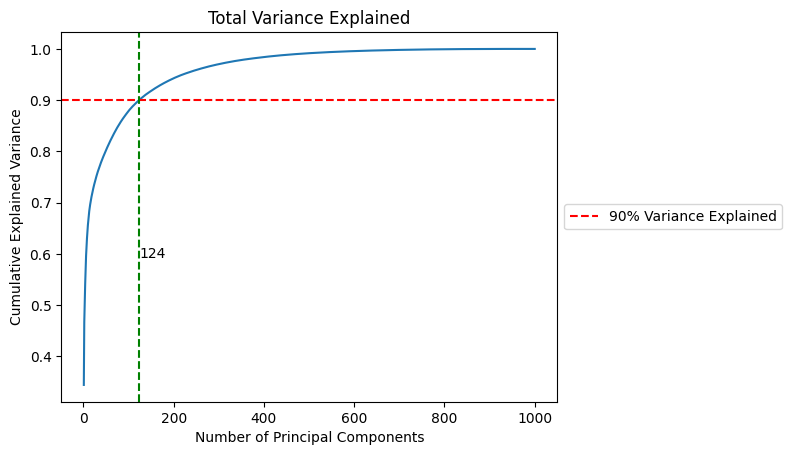

In [69]:
# Calculate cumulative explained variance
cumulative_variance = explained_variance_ratio.cumsum()
# Create total variance explained plot with a line
plt.plot(range(1, len(cumulative_variance) + 1), cumulative_variance, marker='', linestyle='-')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Total Variance Explained')
# Add a line at 80% cumulative explained variance
plt.axhline(y=0.9, color='r', linestyle='--', label='90% Variance Explained')
plt.legend()
# Find the index where cumulative variance exceeds 90%
idx = next(x for x, value in enumerate(cumulative_variance) if value >= 0.9)
# Add a vertical line at the intersection point
plt.axvline(x=idx + 1, color='g', linestyle='--')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

# Plot the index of intersection on the x-axis
plt.text(idx + 1, 0.6, f'{idx + 1}', ha='left', va='center')

plt.show()

In [70]:
n_comp = 150
pca = PCA(n_components=n_comp)
df_tfidf_pca = pca.fit_transform(df_tfidf_reduced)

df_filtered_pca = pd.DataFrame(df_tfidf_pca, columns=[f'PC{i}' for i in range(1, n_comp+1)])

df_filtered_pca.head()

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,...,PC141,PC142,PC143,PC144,PC145,PC146,PC147,PC148,PC149,PC150
0,0.023167,-0.046313,-0.028519,0.047410,0.085532,-0.012270,-0.009565,-0.008394,-0.009469,-0.002498,...,-0.000011,0.000130,-0.000024,-0.000100,-0.000012,-0.000019,0.000013,-0.000068,-0.000085,-0.000002
1,0.059469,-0.022842,-0.008495,-0.013605,-0.006901,0.005940,0.006660,-0.004726,-0.007923,-0.002728,...,-0.000311,-0.000082,0.000869,-0.000015,0.000338,0.000512,-0.000375,-0.001985,-0.001014,-0.000053
2,0.045317,-0.011849,-0.008404,-0.012618,-0.007292,-0.007545,-0.006109,-0.003990,-0.006837,-0.002274,...,0.000149,-0.000323,-0.000176,0.000018,0.000155,0.000071,-0.000133,0.000135,-0.000057,0.000070
3,-0.019097,-0.027370,-0.017925,0.021551,0.005403,-0.005234,0.040481,-0.005684,0.010276,0.000434,...,0.000082,-0.000193,0.000079,0.000237,0.000132,0.000233,0.000058,0.000097,-0.000005,-0.000155
4,-0.031130,-0.042471,-0.009226,-0.010574,-0.006429,-0.005042,0.034107,-0.004006,-0.004989,-0.001224,...,0.000057,0.000071,-0.000267,-0.000165,-0.000349,-0.000180,0.000112,-0.000068,-0.000099,-0.000009


In [71]:
#############
# new data frame containing all the numerical features
############
new_df = pd.concat([df.reset_index(drop=True), df_filtered_pca.reset_index(drop=True)], axis = 1)
new_df = new_df.reset_index(drop=True)
new_df.head()

,Lyrics,Nb_Lines,Nb_Words,Raw_Lyrics,Title,Artist,RID_SECONDARY:INSTRUMENTAL:BEHAVIOR,RID_EMOTIONS:EXPRESSIVE:BEHAVIOR,RID_SECONDARY:TEMPORAL:REFERENCES,RID_PRIMARY:SENSATION:SOUND,...,PC141,PC142,PC143,PC144,PC145,PC146,PC147,PC148,PC149,PC150
0,"[[take, it, easi, with, me, pleas], [touch, me...",47,260,"\nTake it easy with me, please\nTouch me gentl...",andante andante,0,0.066176,0.040441,0.036765,0.033088,...,-0.000011,0.000130,-0.000024,-0.000100,-0.000012,-0.000019,0.000013,-0.000068,-0.000085,-0.000002
1,"[[ahhaha, ahaaaah], [ahhaha, ahaaaah], [ahhaha...",49,313,"\nAh-ha-ha, ah-aaaah\nAh-ha-ha, ah-aaaah\nAh-h...",angeleyes,0,0.032877,0.005479,0.024658,0.008219,...,-0.000311,-0.000082,0.000869,-0.000015,0.000338,0.000512,-0.000375,-0.001985,-0.001014,-0.000053
2,"[[day, is, dawn, and, i, must, go], [you'r, as...",28,190,\nDay is dawning and I must go\nYou're asleep ...,another town another train,0,0.040816,0.005102,0.015306,0.000000,...,0.000149,-0.000323,-0.000176,0.000018,0.000155,0.000071,-0.000133,0.000135,-0.000057,0.000070
3,"[[i'll, never, know, whi, i, had, to, go], [wh...",33,312,\nI'll never know why I had to go\nWhy I had t...,as good as new,0,0.015528,0.000000,0.012422,0.000000,...,0.000082,-0.000193,0.000079,0.000237,0.000132,0.000233,0.000058,0.000097,-0.000005,-0.000155
4,"[[make, somebodi, happi, is, a, question, of, ...",34,200,\nMaking somebody happy is a question of give ...,bangaboomerang,0,0.011673,0.000000,0.019455,0.143969,...,0.000057,0.000071,-0.000267,-0.000165,-0.000349,-0.000180,0.000112,-0.000068,-0.000099,-0.000009


In [72]:
from sklearn.preprocessing import StandardScaler

numerical_df = new_df.drop(['Artist', 'Lyrics', 'Title', 'Raw_Lyrics'], axis=1)
numerical_df.head()

,Nb_Lines,Nb_Words,RID_SECONDARY:INSTRUMENTAL:BEHAVIOR,RID_EMOTIONS:EXPRESSIVE:BEHAVIOR,RID_SECONDARY:TEMPORAL:REFERENCES,RID_PRIMARY:SENSATION:SOUND,RID_SECONDARY:SOCIAL:BEHAVIOR,RID_PRIMARY:SENSATION:VISION,RID_PRIMARY:SENSATION:SOFT,RID_SECONDARY:ABSTRACTION,...,PC141,PC142,PC143,PC144,PC145,PC146,PC147,PC148,PC149,PC150
0,47,260,0.066176,0.040441,0.036765,0.033088,0.025735,0.018382,0.011029,0.011029,...,-0.000011,0.000130,-0.000024,-0.000100,-0.000012,-0.000019,0.000013,-0.000068,-0.000085,-0.000002
1,49,313,0.032877,0.005479,0.024658,0.008219,0.002740,0.038356,0.000000,0.041096,...,-0.000311,-0.000082,0.000869,-0.000015,0.000338,0.000512,-0.000375,-0.001985,-0.001014,-0.000053
2,28,190,0.040816,0.005102,0.015306,0.000000,0.010204,0.005102,0.000000,0.045918,...,0.000149,-0.000323,-0.000176,0.000018,0.000155,0.000071,-0.000133,0.000135,-0.000057,0.000070
3,33,312,0.015528,0.000000,0.012422,0.000000,0.015528,0.003106,0.000000,0.043478,...,0.000082,-0.000193,0.000079,0.000237,0.000132,0.000233,0.000058,0.000097,-0.000005,-0.000155
4,34,200,0.011673,0.000000,0.019455,0.143969,0.007782,0.003891,0.000000,0.031128,...,0.000057,0.000071,-0.000267,-0.000165,-0.000349,-0.000180,0.000112,-0.000068,-0.000099,-0.000009


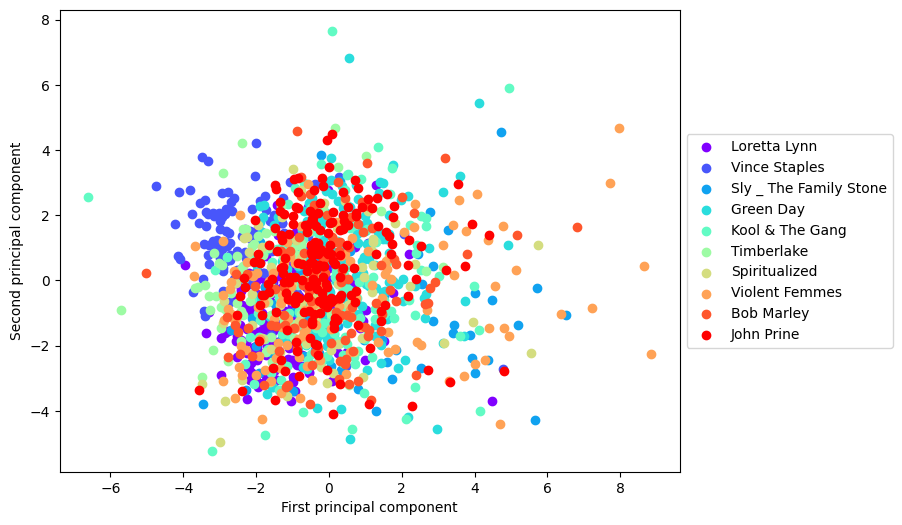

In [73]:
y = new_df["Artist"].to_list()
y = np.array([int(yy) for yy in y])


scaler = StandardScaler()
numerical_df_scaled = scaler.fit_transform(numerical_df)

pca = PCA(n_components=2).fit(numerical_df_scaled)
data2D = pca.transform(numerical_df_scaled)

artist_labels = [arts_dict_op[i] for i in sample]

# Create separate scatter plots for each unique label
colors = plt.cm.rainbow(np.linspace(0, 1, len(sample)))  # Generate a range of colors

fig, ax = plt.subplots(figsize=(8, 6))

for label, art, color in zip(sample, artist_labels, colors):
    mask = (y == label)
    scatter = ax.scatter(data2D[:, 0][mask], data2D[:, 1][mask], c=[color], label=art)

ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax.set_xlabel('First principal component')
ax.set_ylabel('Second principal component')

# Save the plot as an image
#save_path = os.path.join(save_dir, 'PCA_all_feat.png')
#plt.savefig(save_path, bbox_inches='tight', bbox_extra_artists=[ax.legend_])

plt.show()

In [74]:
scaler = StandardScaler()
numerical_df_scaled = scaler.fit_transform(numerical_df)

pca = PCA(n_components=2).fit(numerical_df_scaled)
data2D = pca.transform(numerical_df_scaled)

import itertools
import random

# Define the sampled indices and artist labels for each graph
combinations = list(itertools.combinations(arts_dict_op.keys(), 2))
random.shuffle(combinations)
sampled_indices = combinations[:4]
artist_labels_list = [[arts_dict_op[i] for i in indices] for indices in sampled_indices]


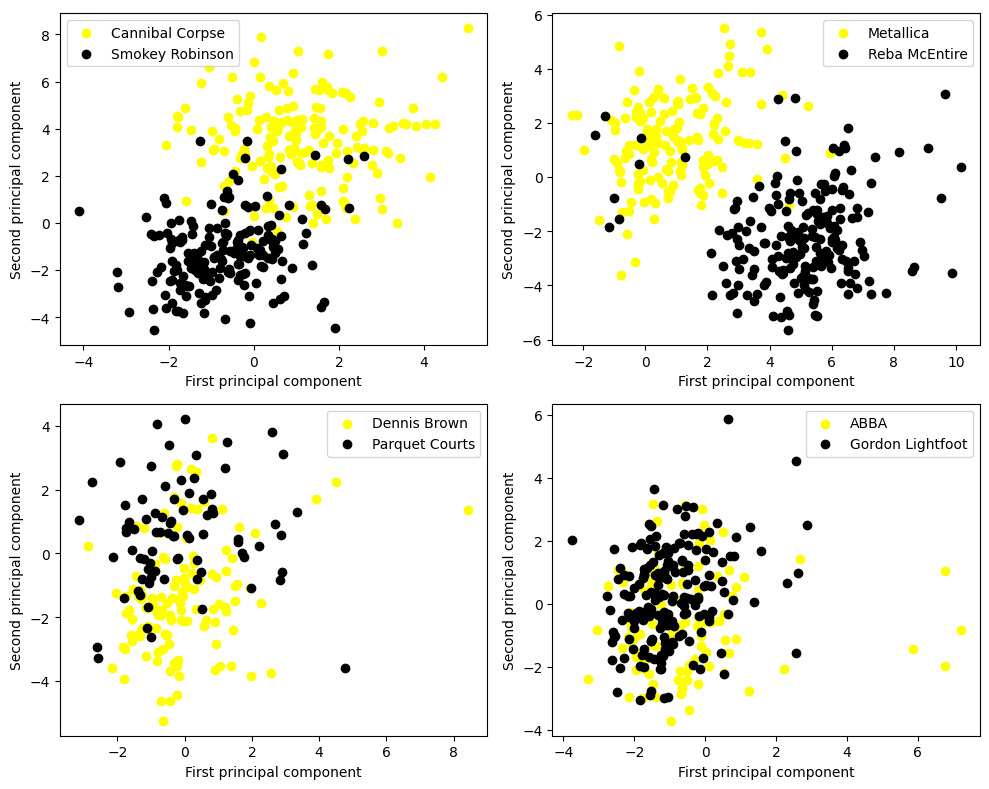

In [75]:
# Assign red and yellow to the first and second labels, respectively
colors_list = ['yellow', 'black']

# Plot the graphs using a loop
plt.figure(figsize=(10, 8))

for i, indices in enumerate(sampled_indices):
    plt.subplot(2, 2, i + 1)
    for j, label in enumerate(indices):
        mask = (y == label)
        color = colors_list[j % 2]  # Alternate between red and yellow
        scatter = plt.scatter(data2D[:, 0][mask], data2D[:, 1][mask], c=color, label=artist_labels_list[i][j])
    plt.xlabel('First principal component')
    plt.ylabel('Second principal component')
    plt.legend()
    #save_path = os.path.join(save_dir, f'plot_2arts_PCA2_second.png')
    #plt.savefig(save_path)

plt.tight_layout()
plt.show()

In [76]:
def create_tfidfvector(df):
    if 'TFIDF_Vector' in df.columns:
        df.drop('TFIDF_Vector', inplace=True, axis=1)

    pca_arrays = []
    for index, row in df.iterrows():
        pca_columns = row[df.columns.str.startswith('PC')].values
        pca_arrays.append(np.array(pca_columns))

    df['TFIDF_Vector'] = pca_arrays

create_tfidfvector(new_df)

In [77]:
# train_indices = train_df.index
# test_indices = test_df.index
# train_df = new_df.iloc[train_indices]
# test_df = new_df.iloc[test_indices]

train_indices = train_df.index
test_indices = test_df.index
train_df = new_df.iloc[train_indices]
test_df = new_df.iloc[test_indices]
('TFIDF_Vector' in train_df.columns)

True

# GET THE TESTING DATA

In [78]:
scaler = StandardScaler()

# x_train = train_df.drop(['Artist', 'Lyrics', 'Title', 'Raw_Lyrics'], axis=1)
# #x_train = pd.DataFrame(scaler.fit_transform(x_train), columns=x_train.columns)
# y_train = np.array(train_df['Artist'].to_list())

# x_test = test_df.drop(['Artist', 'Lyrics', 'Title', 'Raw_Lyrics'], axis=1)
# #x_test = pd.DataFrame(scaler.fit_transform(x_test), columns=x_test.columns)
# y_test = np.array(test_df['Artist'].tolist())

num_train = train_df.drop(['Lyrics', 'Title', 'Raw_Lyrics'], axis=1)
#x_train = pd.DataFrame(scaler.fit_transform(x_train), columns=x_train.columns)

num_test = test_df.drop(['Lyrics', 'Title', 'Raw_Lyrics'], axis=1)
#x_test = pd.DataFrame(scaler.fit_transform(x_test), columns=x_test.columns)

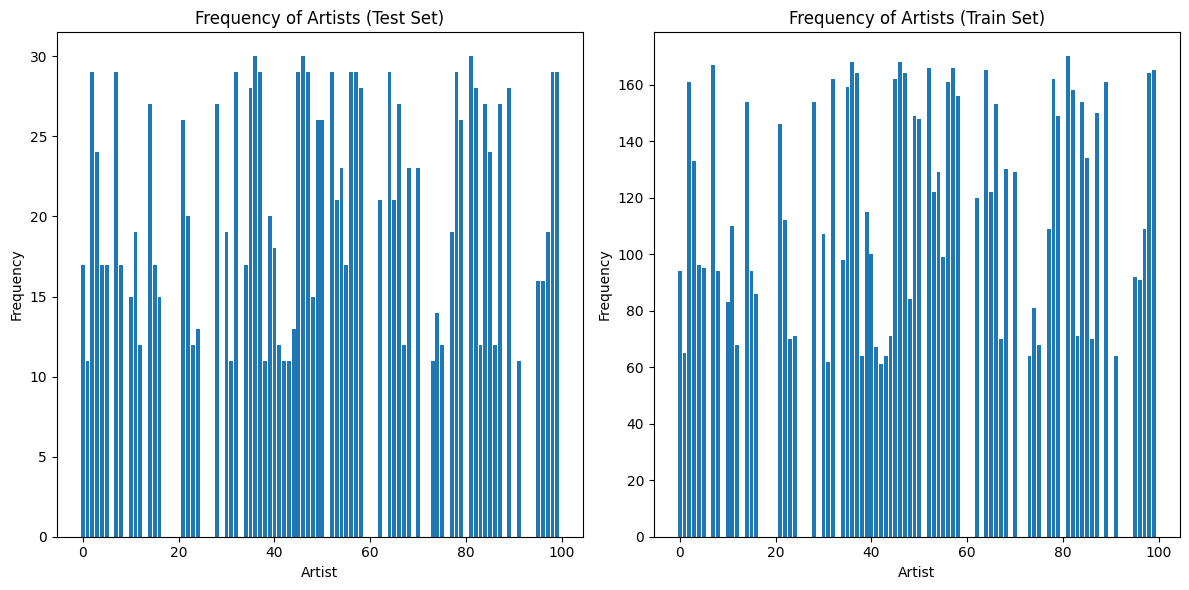

In [79]:
# Count the occurrences of each artist in the test set
artist_counts_test = num_test['Artist'].value_counts()

# Count the occurrences of each artist in the train set
artist_counts_train = num_train['Artist'].value_counts()

# Create a figure with two subplots
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Plot the artist frequencies for the test set
axes[0].bar(artist_counts_test.index, artist_counts_test.values)
axes[0].set_xlabel('Artist')
axes[0].set_ylabel('Frequency')
axes[0].set_title('Frequency of Artists (Test Set)')

# Plot the artist frequencies for the train set
axes[1].bar(artist_counts_train.index, artist_counts_train.values)
axes[1].set_xlabel('Artist')
axes[1].set_ylabel('Frequency')
axes[1].set_title('Frequency of Artists (Train Set)')

# Adjust the layout and spacing between subplots
plt.tight_layout()

# Show the plot
plt.show()

# KNN STARTS

In [80]:
def learn_knn(**kwargs):
    
    model = neighbors.KNeighborsClassifier(**kwargs)
    model.fit(x_train, y_train)
    y_pred = model.predict(x_test)
    acc = metrics.accuracy_score(y_test, y_pred)

    return acc

In [81]:
def run_knn():
    w_accu=[]
    nw_accu=[]
    l1_nw_accu=[]
    l1_w_accu=[]
    max_nei = 50
    big = (0,0,0)

    for i in range(1,max_nei):

        w_accu.append(learn_knn(n_neighbors=i, weights='distance'))
        nw_accu.append(learn_knn(n_neighbors=i))
        l1_w_accu.append(learn_knn(n_neighbors=i, weights='distance', p=1))
        l1_nw_accu.append(learn_knn(n_neighbors=i, p=1))

        if w_accu[-1] > big[0]:
            big = (w_accu[-1], i, 0)

        if nw_accu[-1] > big[0]:
            big = (nw_accu[-1], i, 1)

        if l1_w_accu[-1] > big[0]:
            big = (l1_w_accu[-1], i, 2)

        if l1_nw_accu[-1] > big[0]:
            big = (l1_nw_accu[-1], i, 3)

    best_acc = big[0]
    best_nei = big[1]
    best_param = big[2]

    if best_param == 0:
        best_param = "weighted"
    elif best_param == 1:
        best_param = "not weighted"
    elif best_param == 2:
        best_param = "weighted, L1 distance"
    elif best_param == 3:
        best_param = "not weighted, L1 distance"

    print(f'Best accuracy: {best_acc}\nWith: {best_nei} neighbors, parameters: {best_param}')

In [82]:
def plot_knn():
    # Create a list of x-values for the parameter variations (e.g., parameter values from 1 to 30)
    x_values = list(range(1, max_nei))

    # Plot the accuracies
    plt.plot(x_values, nw_accu, marker='', label = 'not weighted')
    plt.plot(x_values, w_accu, marker = '', label = 'weighted')
    plt.plot(x_values, l1_nw_accu, marker='', label = 'not weighted, L1 distance')
    plt.plot(x_values, l1_w_accu, marker = '', label = 'weighted, L1 distance')

    # Add labels and title to the plot
    plt.xlabel('Number of neighbours')
    plt.ylabel('Accuracy')
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

    # Show the plot
    plt.show()

In [83]:
def test_knn():
    model = neighbors.KNeighborsClassifier(n_neighbors=best_nei, weights= 'distance', p=1)
    model.fit(x_train, y_train)
    scores = cross_val_score(model, x_train, y_train, cv=5)
    print("Accuracy scores:", scores)

In [84]:
#y_pred = model.predict(x_test)
#accuracy = sklearn.metrics.accuracy_score(y_test, y_pred)
#print(accuracy)

In [85]:
def confusion_matrix(y_test, y_pred):
    
     
    y_test_labels = [arts_dict_op[y] for y in y_test]
    y_pred_labels = [arts_dict_op[y] for y in y_pred]
    
    
    confusion_matrix = metrics.confusion_matrix(y_true=y_test_labels, y_pred=y_pred_labels)
    
    #index_labels = list(map(lambda artist: 'actual ' + artist, artists))
    index_labels = list(map(lambda artist: artist, arts_dict_op.keys()))

    #column_labels = list(map(lambda artist: 'predicted ' + artist, artists))
    column_labels = list(map(lambda artist: artist, arts_dict_op.keys()))

    df = pd.DataFrame(data=confusion_matrix, index=index_labels, columns=column_labels)
    
    
    df.style.set_properties(**{'width':'6em', 'text-align':'center'}).set_table_styles([dict(selector="th", props=[('text-align', 'center')])])
   
    return df


# LOGISTIC REGRESSION STARTS

In [86]:
def n_sets_func(nsets): 
    artists_set = random.sample(list(arts_dict_op.keys()), nsets)
    pos_w = (nsets-1)/nsets
    neg_w = 1/nsets
    return artists_set, pos_w, neg_w


In [87]:
def n_sets_func_mine(df, art_set):    
    df2 = df.drop(df.columns[[0, 3, 4]], axis=1)
    df2.reset_index(drop=True, inplace=True)
    df2 = df2[df2['Artist'].isin(art_set)]
    n_art = len(art_set)
    pos_w = (n_art-1)/n_art
    neg_w = 1/n_art
    fts = df2.columns
    return df2, fts, pos_w, neg_w

In [88]:
def mean_of_arrays(matrix):
    mean_values = np.mean(matrix, axis=0)
    return mean_values.tolist()

In [89]:
def artist_df(artist, df):
    """
    takes the aritst number and the training dataframe
    returns the mean and std devaition for all somgs of that artist in that dataframe
    """
    #print(df["TFIDF_Vector"])
    art_data = df[df['Artist'] == artist]
    arrays = art_data['TFIDF_Vector'].values
    #print(arrays)
    # Convert the arrays into a matrix
    matrix = np.stack(arrays)
    mean = np.array(mean_of_arrays(matrix))
    # Calculate the average features for artist number 4
    average_features_artist = art_data.mean(numeric_only=True)
    # Calculate the standard deviation of features for artist number 4
    std_features_artist = art_data.std(numeric_only=True)
    k= ((pd.DataFrame({'Average': average_features_artist, 'Standard Deviation': std_features_artist})).transpose()).drop("Artist", axis=1)
    return k,mean


In [90]:
def cosine_angle(vector1, vector2):
    """
    Similarity between 2 vectors between 0 and 1. To be used for PCAd TFIDF components.
    """
    dot_prod = np.dot(vector1, vector2)
    mag1 = np.linalg.norm(vector1)
    mag2 = np.linalg.norm(vector2)
    if(mag1 *mag2 !=0):
        return dot_prod / (mag1 * mag2)
    return 0
    

In [91]:
def std_rows(df):
    """
    Takes a dataframe with the first 2 rows belonging to an artist and the following rows representing songs.
    Returns the dataframe to be trained for that artist.
    """
    art_pca = df.iloc[0, -1]

    for i in range(2, len(df)):
        df.iloc[i, -1] = cosine_angle(art_pca, df.iloc[i, -1])

    first_row = df.iloc[0, :-1]
    s_row = df.iloc[1, :-1]

    mask = s_row != 0  # Create a mask to avoid division by zero
    df.iloc[2:, :-1] = (first_row - df.iloc[2:, :-1]) / np.where(mask, s_row, 1)

    df = df.iloc[2:].reset_index(drop=True)
    return df


In [92]:
#### WIll make the dataframe of songs for any artist
def df_maker(artist, df, df2):
    """ 
    INPUTS
    artist- aritst number, int
    df- dataframe with songs and their features
    output- dataframe with featurs of the song wrt the aritst
    """
    art_df, meanpca = artist_df(artist, df2)
    art_df["TFIDF_Vector"] = [meanpca, None]
    comb_df = pd.concat([art_df, df])
    return (std_rows(comb_df))

In [93]:
def top_K_accs(y_test, arr):
    
    y_test = np.array(y_test)
    l = len(y_test)
    top_accs=[]
    for max_indices in arr:
        s=0
        for i in range(0,l):
            if y_test[i] in max_indices[i]:
                s+=1
        top_accs.append(100*s/l)
    return(top_accs)

In [94]:
def logistic_test(artists_set, top, x_train, x_test):

    df2, _, pos_w, neg_w = n_sets_func_mine(df=x_train, art_set = artists_set)
    x_train = df2.drop('Artist', axis=1)
    y_train = df2['Artist']

    
    df3, _, pos_w, neg_w = n_sets_func_mine(df=x_test, art_set = artists_set)
    x_test = df3.drop('Artist', axis=1)
    y_test = df3['Artist']
    fts = x_train.columns
    
    probs =[]
    coeffs=[]

    for i in artists_set:
        X2 = df_maker(artist = i,df = x_train, df2= df2)
        X2 = pd.concat([X2.reset_index(drop=True), x_train.iloc[:,:-1].reset_index(drop=True)], axis=1)
        X3 = (df_maker(artist =i,df = x_test, df2=df2))
        X3 = pd.concat([X3.reset_index(drop=True), x_test.iloc[:, :-1].reset_index(drop=True)], axis =1)
        y2 = np.array([1 if x == i else 0 for x in y_train])
        # Split the data into training and testing sets
        logreg = LogisticRegression(max_iter=5000, solver='lbfgs', class_weight={0: neg_w, 1: pos_w})
        logreg.fit(X2, y2)
        coefficients = logreg.coef_
        coeffs.append(coefficients[0])
        probs.append(logreg.predict_proba(X3)[:, 1])
    coeffs = np.vstack(coeffs)
    coeffs= np.mean(coeffs, axis=0)
    probs = np.array(probs)
    probs_by_tops=[]
    for i in top:
        Q = (np.argsort(probs, axis=0)[-i:, :]).transpose()
        temp = []
        for i in Q:
            temp2=[]
            for j in i:
                temp2.append(artists_set[j])
            temp.append(temp2)
        probs_by_tops.append(temp)
    return probs_by_tops, top_K_accs(y_test=y_test,arr= probs_by_tops), coeffs, y_test, fts, artists_set

In [95]:

def logistic_train_acc(artists_set, top, x_train):

    df2, _, pos_w, neg_w = n_sets_func_mine(df=x_train, art_set = artists_set)
    x_train = df2.drop('Artist', axis=1)
    y_train = df2['Artist']

    probs =[]

    for i in artists_set:
        X2 = df_maker(artist = i,df = x_train, df2= df2)
        X2 = pd.concat([X2.reset_index(drop=True), x_train.iloc[:,:-1].reset_index(drop=True)], axis=1)
        y2 = np.array([1 if x == i else 0 for x in y_train])
        # Split the data into training and testing sets
        logreg = LogisticRegression(max_iter=5000, solver='lbfgs', class_weight={0: neg_w, 1: pos_w})
        logreg.fit(X2, y2)
        probs.append(logreg.predict_proba(X2)[:, 1])
    probs = np.array(probs)
    probs_by_tops=[]
    for i in top:
        Q = (np.argsort(probs, axis=0)[-i:, :]).transpose()
        temp = []
        for i in Q:
            temp2=[]
            for j in i:
                temp2.append(artists_set[j])
            temp.append(temp2)
        probs_by_tops.append(temp)
    return top_K_accs(y_test=y_train,arr= probs_by_tops)

In [96]:
def logistic_test_random_bagging(artists_set, top, x_train, x_test, nest, max_sam, max_fts, oob, warm):

    df2, _, pos_w, neg_w = n_sets_func_mine(df=x_train, art_set = artists_set)
    x_train = df2.drop('Artist', axis=1)
    y_train = df2['Artist']

    df3, _, pos_w, neg_w = n_sets_func_mine(df=x_test, art_set = artists_set)
    x_test = df3.drop('Artist', axis=1)
    y_test = df3['Artist']
    fts = x_train.columns
    
    probs =[]

    for i in artists_set:
        X2 = df_maker(artist = i,df = x_train, df2= df2)
        X2 = pd.concat([X2.reset_index(drop=True), x_train.iloc[:,:-1].reset_index(drop=True)], axis=1)
        X3 = (df_maker(artist =i,df = x_test, df2=df2))
        X3 = pd.concat([X3.reset_index(drop=True), x_test.iloc[:, :-1].reset_index(drop=True)], axis =1)
        y2 = np.array([1 if x == i else 0 for x in y_train])
        # Split the data into training and testing sets
        logreg = LogisticRegression(max_iter=5000, solver='lbfgs', class_weight={0: neg_w, 1: pos_w})
        logreg_bagging = BaggingClassifier(estimator=logreg, n_estimators=nest, max_samples=max_sam, max_features=max_fts, oob_score = oob, warm_start=warm)
        logreg_bagging.fit(X2, y2)
        probs.append(logreg_bagging.predict_proba(X3)[:, 1])
    probs = np.array(probs)
    probs_by_tops=[]
    for i in top:
        Q = (np.argsort(probs, axis=0)[-i:, :]).transpose()
        temp = []
        for i in Q:
            temp2=[]
            for j in i:
                temp2.append(artists_set[j])
            temp.append(temp2)
        probs_by_tops.append(temp)
    return  top_K_accs(y_test=y_test,arr= probs_by_tops)

In [97]:
def logistic_test_random_boosting(artists_set, top, x_train, x_test):
    

    df2, _, pos_w, neg_w = n_sets_func_mine(df=x_train, art_set = artists_set)
    x_train = df2.drop('Artist', axis=1)
    y_train = df2['Artist']

    df3, _, pos_w, neg_w = n_sets_func_mine(df=x_test, art_set = artists_set)
    x_test = df3.drop('Artist', axis=1)
    y_test = df3['Artist']
    
    probs =[]

    for i in artists_set:
        X2 = df_maker(artist = i,df = x_train, df2= df2)
        X2 = pd.concat([X2.reset_index(drop=True), x_train.iloc[:,:-1].reset_index(drop=True)], axis=1)
        X3 = (df_maker(artist =i,df = x_test, df2=df2))
        X3 = pd.concat([X3.reset_index(drop=True), x_test.iloc[:, :-1].reset_index(drop=True)], axis =1)
        y2 = np.array([1 if x == i else 0 for x in y_train])
        # Split the data into training and testing sets
        adaboost = AdaBoostClassifier(estimator=LogisticRegression(max_iter=5000),n_estimators=50, learning_rate=1)
        adaboost.fit(X2, y2)
        probs.append(adaboost.predict_proba(X3)[:, 1])
    probs = np.array(probs)
    probs_by_tops=[]
    for i in top:
        Q = (np.argsort(probs, axis=0)[-i:, :]).transpose()
        temp = []
        for i in Q:
            temp2=[]
            for j in i:
                temp2.append(artists_set[j])
            temp.append(temp2)
        probs_by_tops.append(temp)
    return  top_K_accs(y_test=y_test,arr= probs_by_tops)

In [98]:
def misclassy(n, k, l):
    
    # n : number of artists considered
    # k : top k preductions considered
    # l : top l misclassified
    
    misclassified_numbers = Counter()
    artists_set = random.sample(list(arts_dict_op.keys()), n)
    probs_by_tops, accs, _, y_test, _, artists_set = logistic_test(artists_set, top = [k], x_train = num_train,x_test= num_test)

    probs_by_tops = probs_by_tops[0]
    for i, true_value in enumerate(y_test):
        if true_value not in probs_by_tops[i]:
            misclassified_numbers[true_value] += 1

    total_samples = Counter(y_test)  # Count occurrences of each number in y_test

    misclassification_percentages = {
        number: count / total_samples[number] * 100
        for number, count in misclassified_numbers.items()
    }

    top_misclassified = sorted(
        misclassification_percentages.items(), key=lambda x: x[1], reverse=True
    )[:l]

    print(f"The top {l} most misclassified numbers by percentage are:\n")
    for number, percentage in top_misclassified:
        print(f"Number: {arts_dict_op[number]}, Misclassification percentage: {percentage:.2f}%")
        
    return [top[0] for top in top_misclassified]

In [102]:
misclassy(n = 60, k = 8, l = 5)
#num_test['Artist'].value_counts().get(27, 0)

In [100]:
aset =  random.sample(list(arts_dict_op.keys()), 20)
bset = random.sample(list(arts_dict_op.keys()), 40)
cset = random.sample(list(arts_dict_op.keys()), 10)
s=0
top=[1]
arr=[]
for nest in range(9,12,1):
    for max_sam in range (9,11):
        for max_fts in range(9,11):
                for warm in [True, False]:
                    if(warm == False):
                        if(nest<11):
                            continue
                        for oob in [True, False]:
                            a = logistic_test_random_bagging(artists_set=aset, top = top, nest=nest, x_train = num_train, x_test = num_test, max_sam = max_sam/10, max_fts = max_fts/10, oob = oob, warm = warm)
                            b = logistic_test_random_bagging(artists_set=bset, top = top, nest=nest, x_train = num_train, x_test = num_test, max_sam = max_sam/10, max_fts = max_fts/10, oob = oob, warm = warm)
                            c = logistic_test_random_bagging(artists_set=cset, top = top, nest=nest, x_train = num_train, x_test = num_test, max_sam = max_sam/10, max_fts = max_fts/10, oob = oob, warm = warm)
                            brr=[nest,max_sam,max_fts,False, oob, a+b+c]
                            print(brr)
                    else:
                        a = logistic_test_random_bagging(artists_set=aset, top = top, nest=nest, x_train = num_train, x_test = num_test, max_sam = max_sam/10, max_fts = max_fts/10, oob = False, warm = warm)
                        b = logistic_test_random_bagging(artists_set=bset, top = top, nest=nest, x_train = num_train, x_test = num_test, max_sam = max_sam/10, max_fts = max_fts/10, oob = False, warm = warm)
                        c = logistic_test_random_bagging(artists_set=cset, top = top, nest=nest, x_train = num_train, x_test = num_test, max_sam = max_sam/10, max_fts = max_fts/10, oob = False, warm = warm)
                        brr=[nest,max_sam,max_fts,warm, False, a+b+c]
                        print(brr)
                    arr.append(brr)
            

KeyboardInterrupt: 

In [ ]:
# Plot each array of y values
def plot_top_tog(brr, nlist, top):
    brr2 = brr

    max_len = max(len(sublist) for sublist in brr2)
    drr = [[] for _ in range(max_len)]

    for sublist in brr2:
        for i, element in enumerate(sublist):
            drr[i].append(element)

    brr2=drr

    counter=0
    for y_values in brr2:
        plt.plot(nlist[-len(y_values):], y_values, marker='o', label = "top "+str(top[counter])+" choices")
        counter+=1

    # Add labels and title
    plt.xlabel('Number of aritsts')
    plt.ylabel('Accuracy')
    plt.title('Accuracy of n artists with top k choices')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

    # Display the plot
    plt.show()

In [ ]:
def process_data(data, st, name):
    features = data['feature']
    coefficients = data[name]
    
    new_features = []
    new_coefficients = []
    pos_coefficients = []
    pos_total = 0.0
    
    for feature, coefficient in zip(features, coefficients):
        if feature.startswith(st):
            pos_coefficients.append(coefficient)
        else:
            new_features.append(feature)
            new_coefficients.append(coefficient)
    
    if pos_coefficients:
        pos_total = sum(pos_coefficients)
        new_features.append(st)
        new_coefficients.append(pos_total)
    
    processed_data = {
        'feature': new_features,
        name: new_coefficients
    }
    
    return processed_data

In [ ]:
def plotter(data, name):
    feature_importance_df = pd.DataFrame(data)
    sorted_df = feature_importance_df.sort_values(name)
    
    plt.bar(sorted_df['feature'], sorted_df[name], facecolor='gray', align='center')
    plt.xlabel('Feature')  # Reduce the x-axis label size
    plt.ylabel(name)  # Reduce the y-axis label size
    plt.title(f'{name} vs. Feature')  # Reduce the title size
    plt.xticks(rotation=60, ha='right')  # Rotate x-axis labels by 60 degrees and align right
    plt.yticks(fontsize=8)  # Reduce the y-axis tick label size
    plt.ylim(ymin=min(sorted_df[name]), ymax=max(sorted_df[name]))
    plt.show()


In [ ]:
def feature_imp1(crr, fts):    
    for coeffs in crr:
        fts2 = [(element+"DN") for element in fts if element != 'Artist']
        for i in range(0,len(fts2)):
            if(fts2[i] == "PCA diff normal"):
                fts2[i] = "TF_IDF vector similarity"
        fts3 = [element for element in fts if element != 'Artist' and element !='PCA']
        fts2+=fts3
        fts4=[]
        coeffs2=[]
        for i in range(0,len(coeffs)):
            if(np.abs(coeffs[i])>=0.05):
                coeffs2.append(coeffs[i])
                fts4.append(fts2[i])
        data = {'feature': fts4, 'coefficient': coeffs2}
        plotter(data, 'coefficient')



In [ ]:
def feature_imp2(crr, fts):    
    for coeffs in crr:
        fts2 = [(element+" diff normal") for element in fts if element != 'Artist']
        for i in range(0,len(fts2)):
            if(fts2[i] == "PCA diff normal"):
                fts2[i] = "TF_IDF vector similarity"
        fts3 = [element for element in fts if element != 'Artist' and element !='PCA']
        fts2+=fts3
        coeffs2 = np.absolute(coeffs)
        coeffs2 = coeffs2/np.linalg.norm(coeffs2)
        data = {'feature': fts2, 'coefficient': coeffs2}
        for bruh in fts3:
            data = process_data(data, bruh[:4], 'coefficient')
        plotter(data, 'coefficient')

In [ ]:
def feature_imp3(crr, fts):    
    for coeffs in crr:
        fts2 = [(element+" diff normal") for element in fts if element != 'Artist']
        for i in range(0,len(fts2)):
            if(fts2[i] == "PCA diff normal"):
                fts2[i] = "TF_IDF vector similarity"
        fts3 = [element for element in fts if element != 'Artist' and element !='PCA']
        fts2+=fts3
        coeffs2 = np.absolute(coeffs)
        coeffs2 = coeffs2/np.linalg.norm(coeffs2)
        coeffs3 = 100*coeffs2/np.sum(coeffs2)
        data = {'feature': fts2, 'Percentage': coeffs3}
        for bruh in fts3:
            data = process_data(data, bruh[:4], 'Percentage')
        plotter(data, 'Percentage')

In [ ]:
nlist=[2, 4, 8,16]
arr=[]
brr=[]
crr=[]
yrr=[]
top=[]
fts = np.array(df.columns)
for n in nlist:
    print(n)
    top =[2**i for i in range(0, (int)(np.log2(n//2)+1))]
    ar,br,cr,y_test,fts = logistic_test(n_art=n,df =df, top = top)
    arr.append(ar)
    brr.append(br)
    crr.append(cr)
    yrr.append(y_test)
    
plot_top_tog(brr = brr, nlist =nlist, top = top)
#feature_imp1(crr=crr, fts = fts)
#feature_imp2(crr=crr, fts = fts)
#feature_imp3(crr=crr, fts = fts)

2


TypeError: logistic_test() got an unexpected keyword argument 'n_art'